# How do the different analysis methods deal with signals of different lengths?

Geoffrey Brookshire

In [1]:
# Import libraries and set up analyses
%matplotlib inline

import os
os.chdir('..')

In [2]:
import yaml
import copy
import itertools
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import analysis
import simulate_behavior as behav
import simulate_experiments as sim_exp
from analysis_methods import shuff_time, alternatives, utils
from generate_plots import remove_topright_axes
from stat_report_helpers import chi_square_report

# Suppress maximum likelihood estimation convergence warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

USE_CACHE = True  # Whether to use previously-saved simulations

behav_details = yaml.safe_load(open('behav_details.yaml'))

plt.ion()

plot_dir = 'plots/'
n_exp = 1000
behav_kwargs = {'noise_method': 'powerlaw',
                'exponent': 2}
osc_parameters = {'Rand walk': {'f_osc': 0, 'osc_amp': 0},
                  'Rand walk + osc': {'f_osc': 6, 'osc_amp': 0.4}}
method_names = {'LF2012': 'landau',
                'Robust est': 'mann_lees',
                'AR surr': 'ar'}

colors = {'Rand walk': 'red',
          'Rand walk + osc': 'dodgerblue'}

In [3]:
# Colors to plot each signal length
colors_len = {0.5: 'lightcoral',  # Original signal
              1.0: 'blueviolet',  # 1.5 times longer
              2.0: 'mediumblue'}  # 2.0 times longer

In [4]:
def change_signal_length(details, len_ratio):
    """
    Find the new ending time to change the length of the signal
    """
    t_start = details['t_start']
    t_end_orig = details['t_end']
    t_end_new = t_start + ((t_end_orig - t_start) * len_ratio)
    return t_end_new


def siglen_ar(ratio, **behav_kwargs):
    details = behav_details['landau'].copy()
    details['t_end'] = change_signal_length(details, len_ratio)
    x_trial, t_trial = behav.simulate_behavior_trialwise(
        details, **behav_kwargs)
    t, x = utils.avg_repeated_timepoints(t_trial, x_trial)
    res = alternatives.ar_surr(x, details['fs'], details['k_perm'],
                               correction='fdr')
    res['details'] = details
    res['t'] = t
    return res


def siglen_robust_est(len_ratio, re_params={}, **behav_kwargs):
    details = behav_details['landau'].copy()
    details['t_end'] = change_signal_length(details, len_ratio)
    x_trial, t_trial = behav.simulate_behavior_trialwise(
        details, **behav_kwargs)
    t, x = utils.avg_repeated_timepoints(t_trial, x_trial)
    res = alternatives.robust_est(x, details['fs'],
                                  **re_params)
    res['details'] = details
    res['t'] = t
    return res


def siglen_landau(len_ratio, **behav_kwargs):
    details = behav_details['landau'].copy()
    details['t_end'] = change_signal_length(details, len_ratio)
    x_trial, t_trial = behav.simulate_behavior_trialwise(
        details, **behav_kwargs)
    res = shuff_time.landau(x_trial, t_trial,
                            details['fs'], details['k_perm'])
    return res


exp_functions = {'LF2012': siglen_landau,
                 'Robust est': siglen_robust_est,
                 'AR surr': siglen_ar}

In [5]:
len_ratios = (0.5, 1.0, 2.0)

examples = {}
prop_signif = {}
for osc_label, osc_params in osc_parameters.items():
    prop_signif[osc_label] = {}
    examples[osc_label] = {}

    for analysis_meth, exp_fnc in exp_functions.items():

        prop_signif[osc_label][analysis_meth] = {}
        examples[osc_label][analysis_meth] = {}

        for len_ratio in len_ratios:
            if len_ratio == 1:  # Re-use main data for standard length
                desc = ''
            else:
                desc = f'-len_ratio_{len_ratio:.1f}'
            
            def analysis_fnc(**behav_kwargs):
                """ Helper function
                """
                res = exp_fnc(len_ratio,
                              **behav_kwargs)
                return res

            if USE_CACHE or len_ratio == 1:
                lit = analysis.load_simulation(method_names[analysis_meth],
                                               desc=desc,
                                               **behav_kwargs,
                                               **osc_params)

            else:

                lit = analysis.simulate_lit(analysis_fnc, n_exp,
                                            desc=desc,
                                            **behav_kwargs,
                                            **osc_params)
                analysis.save_simulation(lit,
                                         method_names[analysis_meth],
                                         desc=desc,
                                         **behav_kwargs,
                                         **osc_params)

            p = analysis.prop_sig(lit)
            prop_signif[osc_label][analysis_meth][len_ratio] = p
            examples[osc_label][analysis_meth][len_ratio] = lit['result'][0]

loading: results/landau_exp_2.00_f_0.00_amp_0.00-len_ratio_0.5.npy
loading: results/landau_exp_2.00_f_0.00_amp_0.00.npy
loading: results/landau_exp_2.00_f_0.00_amp_0.00-len_ratio_2.0.npy
loading: results/mann_lees_exp_2.00_f_0.00_amp_0.00-len_ratio_0.5.npy
loading: results/mann_lees_exp_2.00_f_0.00_amp_0.00.npy
loading: results/mann_lees_exp_2.00_f_0.00_amp_0.00-len_ratio_2.0.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00-len_ratio_0.5.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00-len_ratio_2.0.npy
loading: results/landau_exp_2.00_f_6.00_amp_0.40-len_ratio_0.5.npy
loading: results/landau_exp_2.00_f_6.00_amp_0.40.npy
loading: results/landau_exp_2.00_f_6.00_amp_0.40-len_ratio_2.0.npy
loading: results/mann_lees_exp_2.00_f_6.00_amp_0.40-len_ratio_0.5.npy
loading: results/mann_lees_exp_2.00_f_6.00_amp_0.40.npy
loading: results/mann_lees_exp_2.00_f_6.00_amp_0.40-len_ratio_2.0.npy
loading: results/ar_exp_2.00_f_6.00_amp_0.40-len_ratio_0.5.

Before going on to the main analysis, let's check whether the signals' length changed as expected.

Because the longer time-series have fewer data points at each time lag (to preserve the total number of observations in the experiment), those signals are noisier.

len_ratio:  27
len_ratio:  52
len_ratio:  103


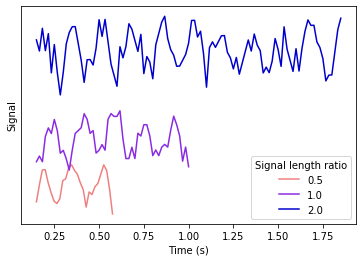

In [6]:
for len_ratio, color in colors_len.items():
    res = examples['Rand walk + osc']['AR surr'][len_ratio]
    print('len_ratio: ', len(res['t']))
    plt.plot(res['t'],
             res['x'] + len_ratio,  # Offset for easier comparison
             color=color,
             label=len_ratio)
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.yticks([])
plt.legend(title='Signal length ratio')

Next, lets look at the spectra, to make sure our simulated oscillation appears at the expected frequency.

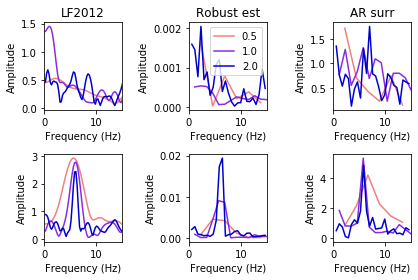

In [7]:
for i_meth, analysis_meth in enumerate(exp_functions.keys()):
    for i_osc, osc_label in enumerate(osc_parameters.keys()):
        plt.subplot(len(osc_parameters),
                    len(exp_functions),
                    (len(exp_functions) * i_osc) + i_meth + 1)
        if i_osc == 0:
            plt.title(analysis_meth)
            
        for ratio, res in examples[osc_label][analysis_meth].items():
            # Normalize amp by signal length (for visualization only)
            if analysis_meth in ('AR surr', 'LF2012'):
                y = res['y_emp'] / ratio
            else:
                y = res['y_emp']
            plt.plot(res['f'], y, '-',
                     label=ratio,
                     color=colors_len[ratio])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.xlim(0, 15)
        if osc_label == 'Rand walk' and analysis_meth == 'Robust est':
                plt.legend()

plt.tight_layout()

In these examples of simulations that include an oscillation (bottom row), we see that the peak appears at the same expected location (6 Hz) regardless of the sampling rate.

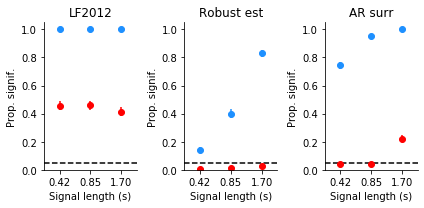

In [8]:
def prop_ci(p, n):
    """ 95% CI of a proportion
    """
    return 1.96 * np.sqrt((p * (1 - p)) / n)

# Length of the signal in seconds
signal_lengths = [r['t'][-1] - r['t'][0]
                  for r in examples['Rand walk']['AR surr'].values()]

plt.figure(figsize=(6, 3))
for i_plot, analysis_meth in enumerate(exp_functions.keys()):
    plt.subplot(1, 3, i_plot + 1)
    plt.title(analysis_meth)
    plt.axhline(y=0.05, color='k', linestyle='--')
    for osc_label in osc_parameters.keys():
        psig = prop_signif[osc_label][analysis_meth]
        labels = psig.keys()
        x_pos = np.arange(float(len(psig)))
        psig = np.array(list(psig.values()))
        plt.errorbar(x_pos, psig,
                     yerr=prop_ci(psig, n_exp),
                     fmt='o',
                     color=colors[osc_label],
                     label=osc_label)
    plt.xticks(x_pos,
               [f'{e:.2f}' for e in signal_lengths])
    plt.xlim([-0.5, len(psig) - 0.5])
    plt.xlabel('Signal length (s)')
    plt.ylim(0, 1.05)
    plt.ylabel('Prop. signif.')
    remove_topright_axes()
    # if i_plot == 1:
    #     plt.legend()
plt.tight_layout()
plt.savefig(f"{plot_dir}signal_length.eps")

## Statistical tests

### Differences between signal lengths

We can test for differences in how the different analysis methods deal with signals of different lengths.

Look within each analysis method across the different sampling rates.

In [9]:
for analysis_meth in exp_functions.keys():
    print(analysis_meth)
    for osc_label in osc_parameters.keys():
        print('-', osc_label)
        psig = prop_signif[osc_label][analysis_meth]
        labels = psig.keys()
        for comp in itertools.combinations(len_ratios, 2):
            # Make a contingency table
            msg = f' - {comp[0]} vs {comp[1]}: '
            p0 = psig[comp[0]]
            p1 = psig[comp[1]]
            tbl = [[p0 * n_exp, p1 * n_exp],
                   [(1 - p0) * n_exp, (1 - p1) * n_exp]]
            tbl = np.array(tbl)
            msg += chi_square_report(tbl)
            print(msg)

LF2012
- Rand walk
 - 0.5 vs 1.0: $\chi^2(1) = 0.0$, $p = 0.9$, $\phi_C = 0.00$ [0.00, 0.05]
 - 0.5 vs 2.0: $\chi^2(1) = 3.3$, $p = 0.07$, $\phi_C = 0.04$ [0.00, 0.09]
 - 1.0 vs 2.0: $\chi^2(1) = 3.9$, $p = 0.05$, $\phi_C = 0.05$ [0.01, 0.09]
- Rand walk + osc
 - 0.5 vs 1.0: Can't compute chi-square; at floor/ceiling
 - 0.5 vs 2.0: Can't compute chi-square; at floor/ceiling
 - 1.0 vs 2.0: Can't compute chi-square; at floor/ceiling
Robust est
- Rand walk
 - 0.5 vs 1.0: $\chi^2(1) = 3.1$, $p = 0.08$, $\phi_C = 0.04$ [0.00, 0.08]
 - 0.5 vs 2.0: $\chi^2(1) = 13.2$, $p = 0.0003$, $\phi_C = 0.09$ [0.05, 0.12]
 - 1.0 vs 2.0: $\chi^2(1) = 3.4$, $p = 0.06$, $\phi_C = 0.04$ [0.01, 0.09]
- Rand walk + osc
 - 0.5 vs 1.0: $\chi^2(1) = 169.8$, $p = 8 \times 10^{-39}$, $\phi_C = 0.29$ [0.25, 0.33]
 - 0.5 vs 2.0: $\chi^2(1) = 947.5$, $p = 5 \times 10^{-208}$, $\phi_C = 0.69$ [0.66, 0.72]
 - 1.0 vs 2.0: $\chi^2(1) = 387.0$, $p = 4 \times 10^{-86}$, $\phi_C = 0.44$ [0.40, 0.48]
AR surr
- Rand walk
 - 0.

Compare between methods for a given sampling rate

In [10]:
for len_ratio in len_ratios:
    print(len_ratio)
    for osc_label in osc_parameters.keys():
        print('-', osc_label)
        labels = psig.keys()
        for comp in itertools.combinations(exp_functions.keys(), 2):
            msg = f' - {comp[0]} vs {comp[1]}: '
            # Make a contingency table
            p0 = prop_signif[osc_label][comp[0]][len_ratio]
            p1 = prop_signif[osc_label][comp[1]][len_ratio]
            tbl = [[p0 * n_exp, p1 * n_exp],
                   [(1 - p0) * n_exp, (1 - p1) * n_exp]]
            tbl = np.array(tbl)
            msg += chi_square_report(tbl)
            print(msg)

0.5
- Rand walk
 - LF2012 vs Robust est: $\chi^2(1) = 567.4$, $p = 2 \times 10^{-125}$, $\phi_C = 0.53$ [0.51, 0.56]
 - LF2012 vs AR surr: $\chi^2(1) = 464.6$, $p = 5 \times 10^{-103}$, $\phi_C = 0.48$ [0.45, 0.52]
 - Robust est vs AR surr: $\chi^2(1) = 23.3$, $p = 1 \times 10^{-06}$, $\phi_C = 0.11$ [0.08, 0.14]
- Rand walk + osc
 - LF2012 vs Robust est: $\chi^2(1) = 1502.2$, $p = 0$, $\phi_C = 0.87$ [0.85, 0.89]
 - LF2012 vs AR surr: $\chi^2(1) = 292.6$, $p = 1 \times 10^{-65}$, $\phi_C = 0.38$ [0.36, 0.41]
 - Robust est vs AR surr: $\chi^2(1) = 732.3$, $p = 3 \times 10^{-161}$, $\phi_C = 0.61$ [0.57, 0.64]
1.0
- Rand walk
 - LF2012 vs Robust est: $\chi^2(1) = 544.3$, $p = 2 \times 10^{-120}$, $\phi_C = 0.52$ [0.49, 0.55]
 - LF2012 vs AR surr: $\chi^2(1) = 456.8$, $p = 2 \times 10^{-101}$, $\phi_C = 0.48$ [0.45, 0.51]
 - Robust est vs AR surr: $\chi^2(1) = 13.7$, $p = 0.0002$, $\phi_C = 0.09$ [0.05, 0.12]
- Rand walk + osc
 - LF2012 vs Robust est: $\chi^2(1) = 852.3$, $p = 2 \times 1

### Comparing false positives against alpha = 0.05

Does each method have a rate of false positives higher than 0.05? If so, that method does not adequately control the rate of false positives. Those methods are marked with an asterisk `*`.

In [11]:
for analysis_meth in exp_functions.keys():
    print(analysis_meth)
    for len_ratio in len_ratios:
        prop = prop_signif['Rand walk'][analysis_meth][len_ratio]
        pval = stats.binom_test(prop * n_exp,
                                n_exp,
                                0.05)
        msg = f'- {len_ratio}: {prop:.2f}, p = {pval:.1e}'
        if prop > 0.05 and pval < 0.05:
            msg += ' *'
        print(msg)

LF2012
- 0.5: 0.46, p = 2.5e-308 *
- 1.0: 0.46, p = 3.7e-313 *
- 2.0: 0.41, p = 1.6e-260 *
Robust est
- 0.5: 0.01, p = 3.5e-15
- 1.0: 0.01, p = 6.6e-09
- 2.0: 0.03, p = 8.0e-04
AR surr
- 0.5: 0.04, p = 1.3e-01
- 1.0: 0.04, p = 4.2e-01
- 2.0: 0.22, p = 1.2e-77 *
